In [4]:
# Importamos librerias:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [5]:
# Leemos los dataset
serie_v = pd.read_csv("/content/covid_total_diario.csv", sep=";", index_col= "fecha")
serie_v.index = pd.to_datetime(serie_v.index, format= "%d/%m/%Y")

data = pd.read_csv("/content/applemobilitytrends-2021-07-23.csv", sep=",")
data=data[data["region"]=="Argentina"]
dates = data.columns[6:]
data_d = data[data["transportation_type"]=="driving"]
serie_d=pd.DataFrame(data=data_d.iloc[0:,6:].transpose())
serie_d = serie_d.rename(columns={2: 'Value'})
serie_d.index = pd.to_datetime(serie_d.index)
serie_d=serie_d.interpolate()

data = pd.read_csv("/content/owid-covid-data.csv", sep=",")
data.index= data.date
data = data[data["location"]== "Argentina"]
serie_c = data.new_cases
serie_c = serie_c.fillna(0)
serie_c = pd.DataFrame(serie_c)
serie_c.index = pd.to_datetime(serie_c.index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


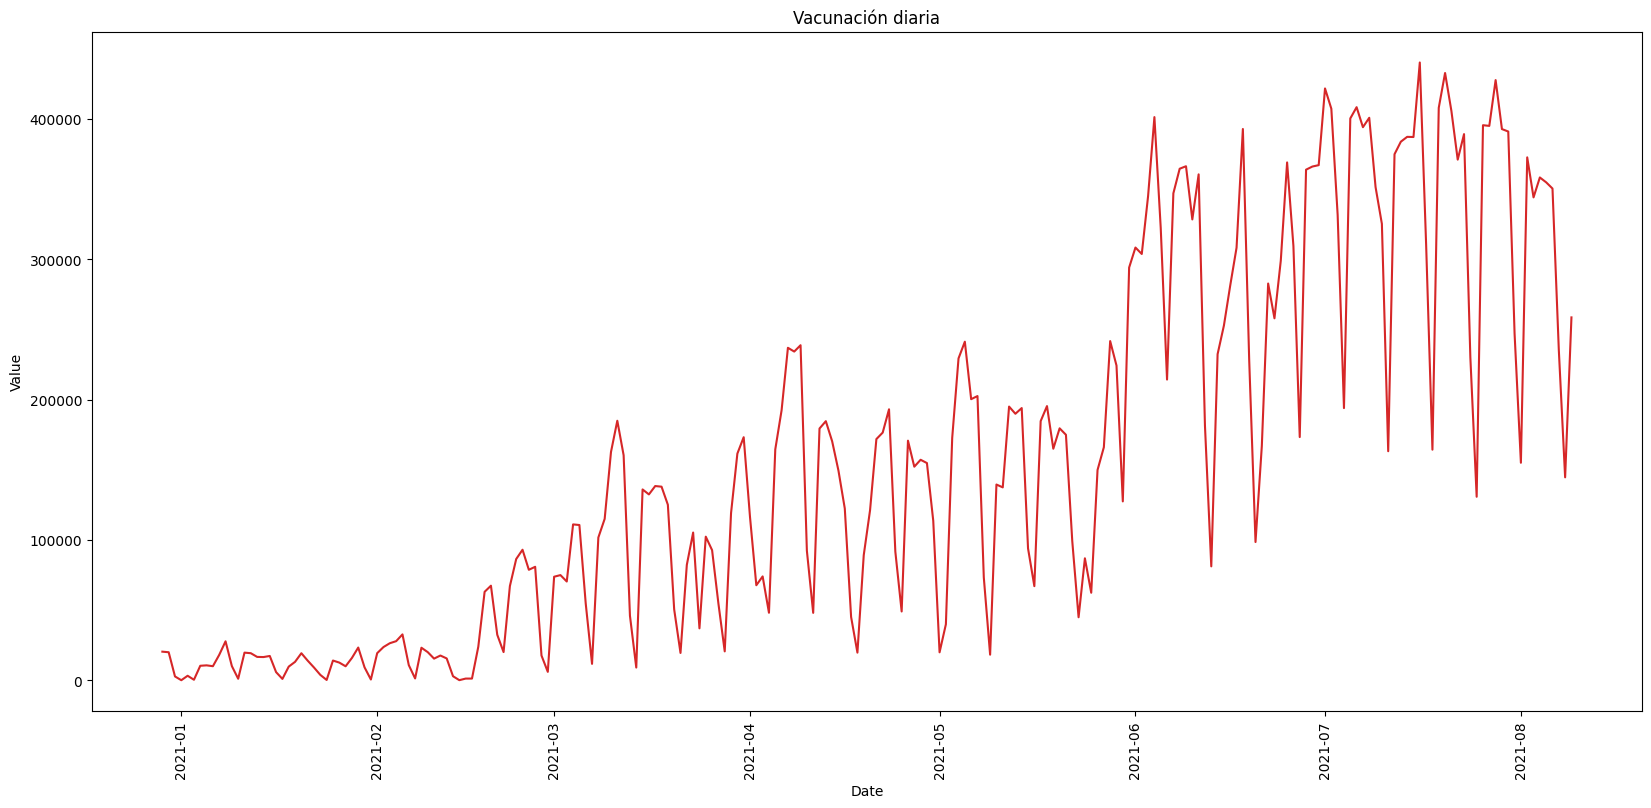

In [6]:
# Gráfico vacunas
def plot_data(data, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,9), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.savefig("Image.png")
    plt.show()
plot_data(serie_v, x=serie_v.index, y=serie_v.total_1ra_y_2da_dosis_aplicadas, title='Vacunación diaria')

In [7]:
# Diferenciamos las 3 series:
serie_v_dif = serie_v
serie_v_dif["Diferences"] = None
for i in range(0,(serie_v_dif.shape[0]-1)):
  serie_v_dif.iloc[(i+1),1]=serie_v_dif.iloc[(i+1),0] - serie_v_dif.iloc[i,0]
serie_v_dif = serie_v_dif.drop("total_1ra_y_2da_dosis_aplicadas", axis=1)

In [8]:
serie_d_dif = serie_d
serie_d_dif["Diferences"] = None
for i in range(0,(serie_d_dif.shape[0]-1)):
  serie_d_dif.iloc[(i+1),1]=serie_d_dif.iloc[(i+1),0] - serie_d_dif.iloc[i,0]
serie_d_dif = serie_d_dif.drop("Value", axis=1)

In [9]:
serie_c_dif = serie_c
serie_c_dif["Diferences"] = None
for i in range(0,(serie_c_dif.shape[0]-1)):
  serie_c_dif.iloc[(i+1),1]=serie_c_dif.iloc[(i+1),0] - serie_c_dif.iloc[i,0]
serie_c_dif = serie_c_dif.drop("new_cases", axis=1)

In [10]:
# Nos quedamos con las mismas fechas en las 3 series:
serie_d_dif = serie_d_dif.loc["2020-12-30":]
serie_c_dif = serie_c_dif.loc["2020-12-30":"2021-07-23"] 
serie_v_dif = serie_v_dif.loc[:"2021-07-23"] 

In [11]:
# Unimos las tres series en un mismo dataset
serie_completa_dif = pd.merge(serie_c_dif,serie_d_dif, left_index = True, right_index = True)
serie_completa_dif = pd.merge(serie_completa_dif,serie_v_dif, left_index = True, right_index = True)

In [12]:
serie_completa_dif = serie_completa_dif.rename(columns={"Diferences_x": "casos_dif", "Diferences_y": "movilidad_dif","Diferences": "vacunas_dif" })

In [13]:
# Test de Causalidad de Granger:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=20
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],20) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(serie_completa_dif, variables = serie_completa_dif.columns) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,casos_dif_x,movilidad_dif_x,vacunas_dif_x
casos_dif_y,9.999999e-01,7.000000e-20,5.270159e-08
movilidad_dif_y,2.387113e-12,1.000000e+00,9.696568e-13
vacunas_dif_y,1.563747e-08,0.000000e+00,1.000000e+00


In [14]:
# P-values menores a 0.05, por lo tanto hay causalidad entre todas las variables

In [16]:
serie_completa_dif_array = np.asarray(serie_completa_dif)

In [17]:
# Dividimos en Train y Test
train = np.asarray(serie_completa_dif.loc['2020-12-30':'2021-06-30'])
test = serie_completa_dif.loc['2021-07-01':'2021-07-23']

In [18]:
# Ajustamos modelos VAR de orden del 1 al 10:
for i in range(10):
    i += 1
    model = sm.tsa.VARMAX(serie_completa_dif_array, order=(i,0))
    model_result = model.fit(maxiter=1000, disp=False)
    print('Order = ', i)
    print('AIC: ', model_result.aic)
    print('BIC: ', model_result.bic)
    print('HQIC: ', model_result.hqic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/representation.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  new = getattr(self, '_' + matrix).astype(dtype)


Order =  1
AIC:  10581.761044398963
BIC:  10641.662815437176
HQIC:  10605.987341288444
Order =  2
AIC:  10542.661250536574
BIC:  10632.513907093893
HQIC:  10579.000695870795
Order =  3
AIC:  10501.519882338434
BIC:  10621.323424414859
HQIC:  10549.972476117395
Order =  4
AIC:  10439.967277412678
BIC:  10589.721705008209
HQIC:  10500.533019636378
Order =  5
AIC:  10365.128662930885
BIC:  10544.833976045522
HQIC:  10437.807553599327
Order =  6
AIC:  10294.377708885435
BIC:  10504.033907519179
HQIC:  10379.169747998616
Order =  7
AIC:  10246.43824401901
BIC:  10486.045328171858
HQIC:  10343.34343157693
Order =  8
AIC:  10255.302386471494
BIC:  10524.86035614345
HQIC:  10364.320722474155
Order =  9
AIC:  10262.828560347396
BIC:  10562.337415538459
HQIC:  10383.960044794798
Order =  10
AIC:  10272.612913368306
BIC:  10602.072654078474
HQIC:  10405.857546260448


In [19]:
# Hacemos el modelo VAR elegido - Orden 7:
model = sm.tsa.VARMAX(train, order=(7,0))
model_fitted = model.fit(maxiter=1000, disp=False)
model_fitted.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/representation.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  new = getattr(self, '_' + matrix).astype(dtype)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:2060: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


Dep. Variable:,"['y1', 'y2', 'y3']",No. Observations:,183
Model:,VAR(7),Log Likelihood,-4486.638
,+ intercept,AIC,9117.276
Date:,"Tue, 17 Aug 2021",BIC,9348.359
Time:,21:17:47,HQIC,9210.946
Sample:,0,,
,- 183,,
Covariance Type:,opg,,
Ljung-Box (Q):,"54.59, 50.97, 48.18",Jarque-Bera (JB):,"40.92, 191.22, 4.75"
Prob(Q):,"0.06, 0.11, 0.18",Prob(JB):,"0.00, 0.00, 0.09"
Heteroskedasticity (H):,"5.58, 1.22, 3.72",Skew:,"0.25, -0.43, 0.10"


In [20]:
lag_order = 7

In [21]:
# Tomamos los últimos valores del conjunto de entrenamiento para hacer el forecast de testeo:
forecast_input = pd.DataFrame(train).values[-lag_order:]

In [22]:
train_df = serie_completa_dif.loc['2020-12-30':'2021-06-30']

In [23]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=len(test))
df_forecast = pd.DataFrame(fc, index= test.index , columns= test.columns + '_forecasted')
future_forecast = pd.DataFrame(df_forecast, index = test.index)


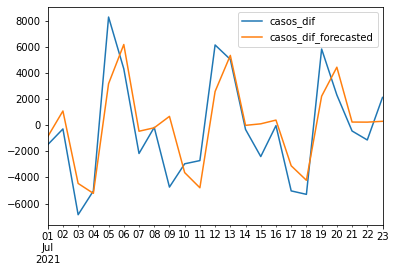

In [24]:
# Comparación casos Covid diferenciada:
comp_casos = pd.concat([test.casos_dif,future_forecast.casos_dif_forecasted],axis=1)
comp_casos.plot()
plt.savefig("Var_casos.png")

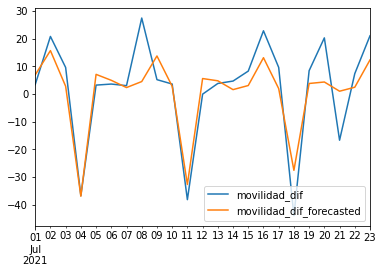

In [25]:
# Comparación movilidad diferenciada:
comp_mov = pd.concat([test.movilidad_dif,future_forecast.movilidad_dif_forecasted],axis=1)
comp_mov.plot()
plt.savefig("Var_mov.png")

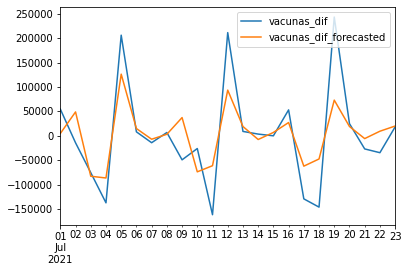

In [26]:
# Comparación vacunación diferenciada:
comp_vac = pd.concat([test.vacunas_dif,future_forecast.vacunas_dif_forecasted],axis=1)
comp_vac.plot()
plt.savefig("Var_vac.png")

In [71]:
future_forecast_vacunas = pd.DataFrame(future_forecast.vacunas_dif_forecasted)
future_forecast_vacunas["original_vacunas"] = None

In [102]:
# Deshacemos la diferenciación Vacunas
future_forecast_vacunas = pd.DataFrame(future_forecast.vacunas_dif_forecasted)
future_forecast_vacunas["forecast_vacunas"] = None
future_forecast_vacunas.iloc[0,1] = serie_v.loc["2021-06-30","total_1ra_y_2da_dosis_aplicadas"] 
for i in range(0,(future_forecast_vacunas.shape[0]-1)):
  future_forecast_vacunas.iloc[(i+1),1]=future_forecast_vacunas.iloc[(i+1),0] + future_forecast_vacunas.iloc[i,1]
future_forecast_vacunas = future_forecast_vacunas.drop("vacunas_dif_forecasted", axis=1)


In [103]:
# Deshacemos la diferenciación Casos
future_forecast_casos = pd.DataFrame(future_forecast.casos_dif_forecasted)
future_forecast_casos["forecast_casos"] = None
future_forecast_casos.iloc[0,1] = serie_c.loc["2021-06-30","new_cases"]
for i in range(0,(future_forecast_casos.shape[0]-1)):
  future_forecast_casos.iloc[(i+1),1] = future_forecast_casos.iloc[(i+1),0] + future_forecast_casos.iloc[i,1]
future_forecast_casos = future_forecast_casos.drop("casos_dif_forecasted", axis=1)
future_forecast_casos = future_forecast_casos.drop(future_forecast_casos.index[0], axis=0)

In [108]:
# Deshacemos la diferenciación Movilidad
future_forecast_mov = pd.DataFrame(future_forecast.movilidad_dif_forecasted)
future_forecast_mov["forecast_movilidad"] = None
future_forecast_mov.iloc[0,1] = serie_d.loc["2021-06-30","Value"]
for i in range(0,(future_forecast_mov.shape[0]-1)):
  future_forecast_mov.iloc[(i+1),1] = future_forecast_mov.iloc[(i+1),0] + future_forecast_mov.iloc[i,1]
future_forecast_mov = future_forecast_mov.drop("movilidad_dif_forecasted", axis=1)
future_forecast_mov = future_forecast_mov.drop(future_forecast_mov.index[0], axis=0)

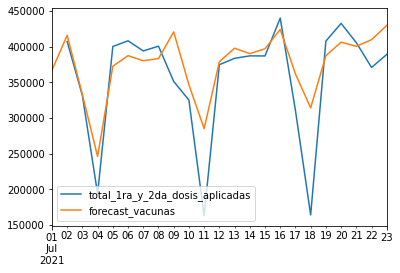

In [105]:
# Comparación vacunación sin diferenciar:
test_v = pd.DataFrame(serie_v.total_1ra_y_2da_dosis_aplicadas.loc['2021-07-02':'2021-07-23'])
comp_vac = pd.concat([test_v.total_1ra_y_2da_dosis_aplicadas, future_forecast_vacunas.forecast_vacunas],axis=1)
comp_vac.plot()
plt.savefig("Var_vac.png")

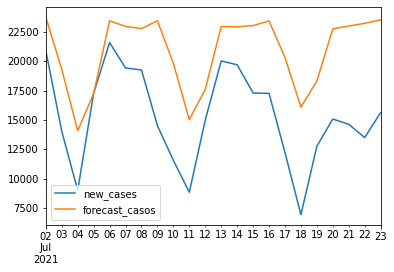

In [106]:
# Comparación cantidad de casos sin diferenciar:
test_c = pd.DataFrame(serie_c.new_cases.loc['2021-07-02':'2021-07-23'])
comp_casos = pd.concat([test_c.new_cases, future_forecast_casos.forecast_casos],axis=1)
comp_casos.plot()
plt.savefig("Var_casos.png")

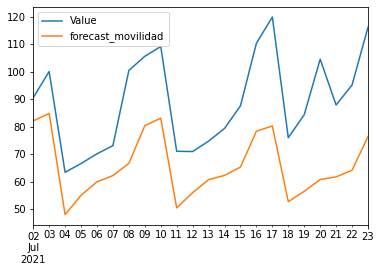

In [109]:
# Comparación movilidad sin diferenciar:
test_m = pd.DataFrame(serie_d.Value.loc['2021-07-02':'2021-07-23'])
comp_mov = pd.concat([test_m.Value, future_forecast_mov.forecast_movilidad],axis=1)
comp_mov.plot()
plt.savefig("Var_mov.png")